   1 Proposal:   -5.82  =>  Current:   -5.82 ACCEPTED


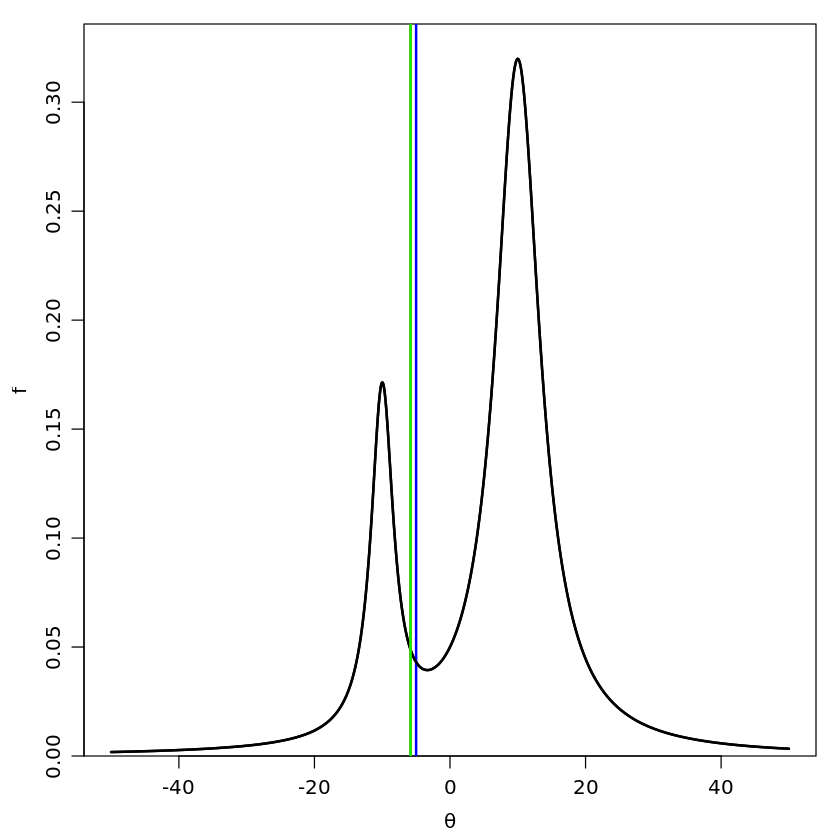

   2 Proposal:   -7.02  =>  Current:   -7.02 ACCEPTED


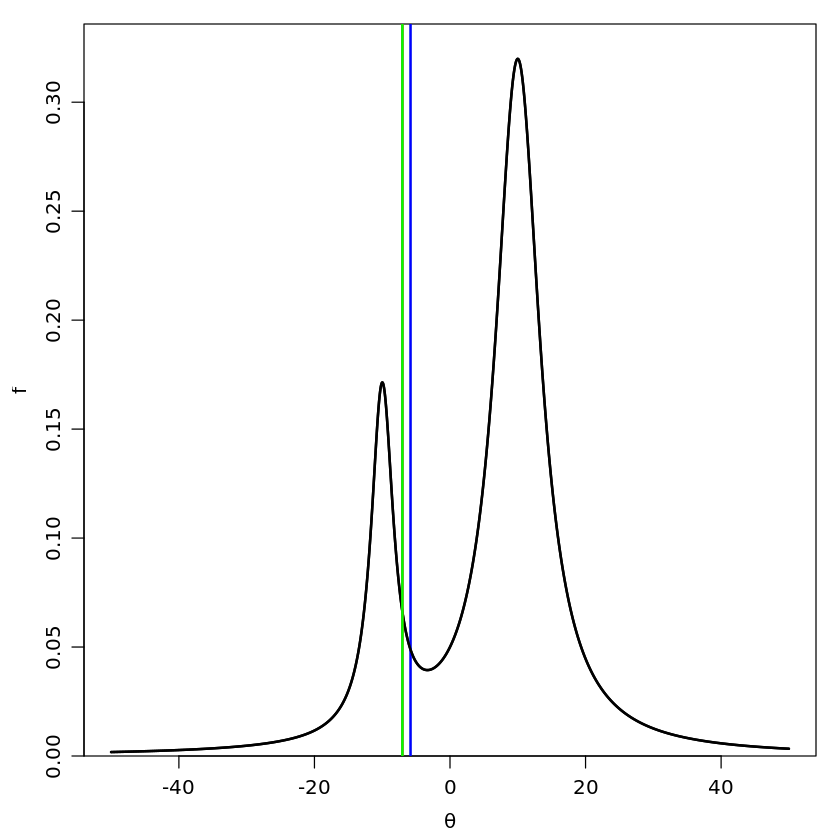

   3 Proposal:   -9.59  =>  Current:   -9.59 ACCEPTED


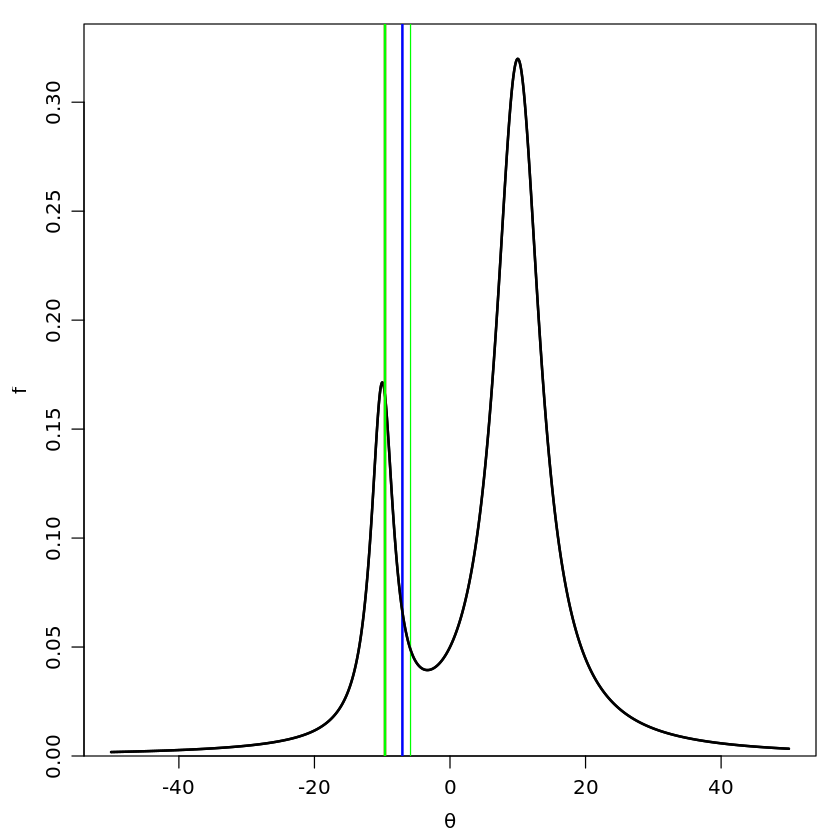

   4 Proposal:   -3.36  =>  Current:   -9.59


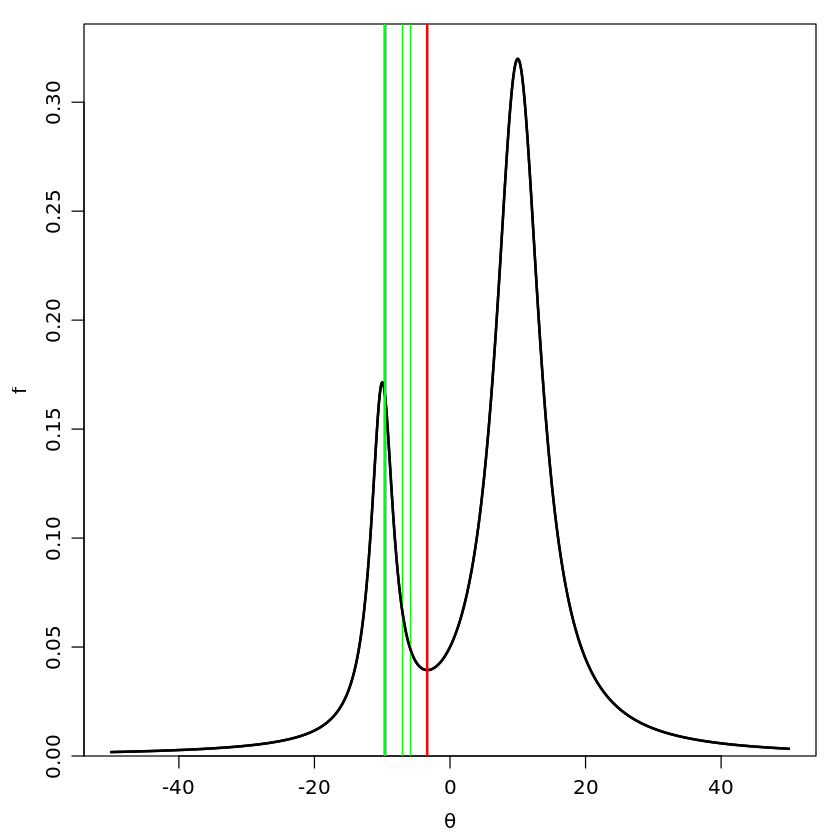

   5 Proposal:   -5.50  =>  Current:   -9.59


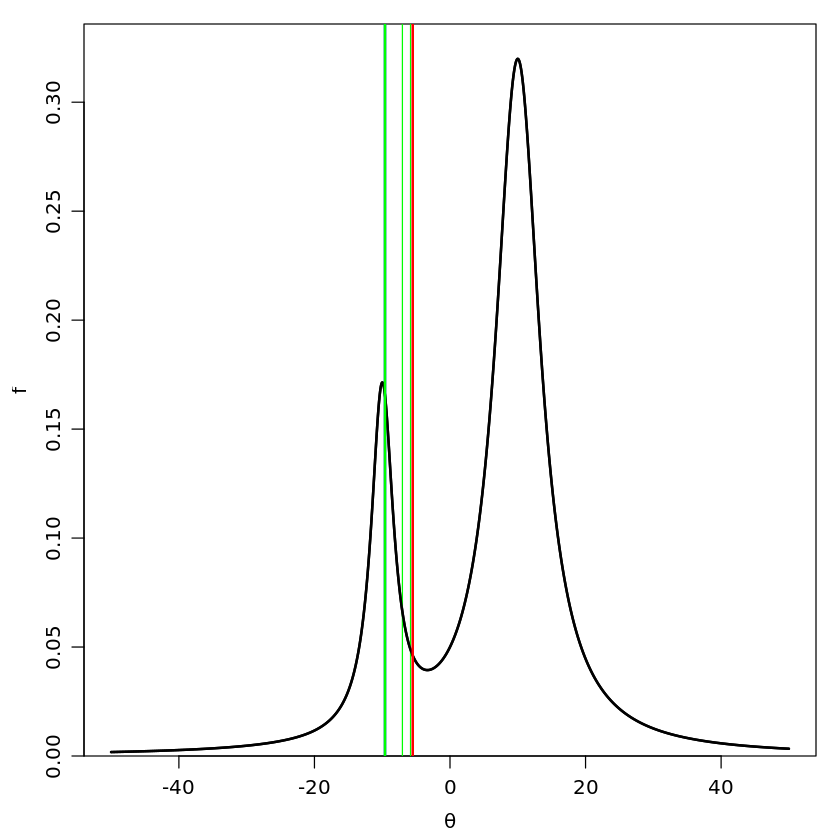

   6 Proposal:  -12.31  =>  Current:   -9.59


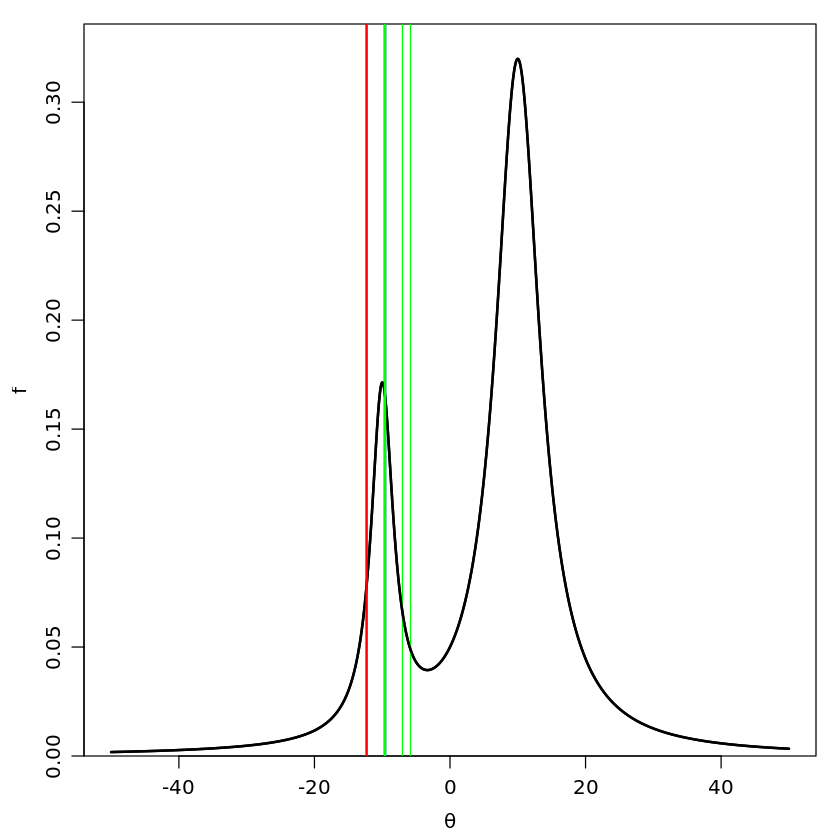

   7 Proposal:  -11.36  =>  Current:  -11.36 ACCEPTED


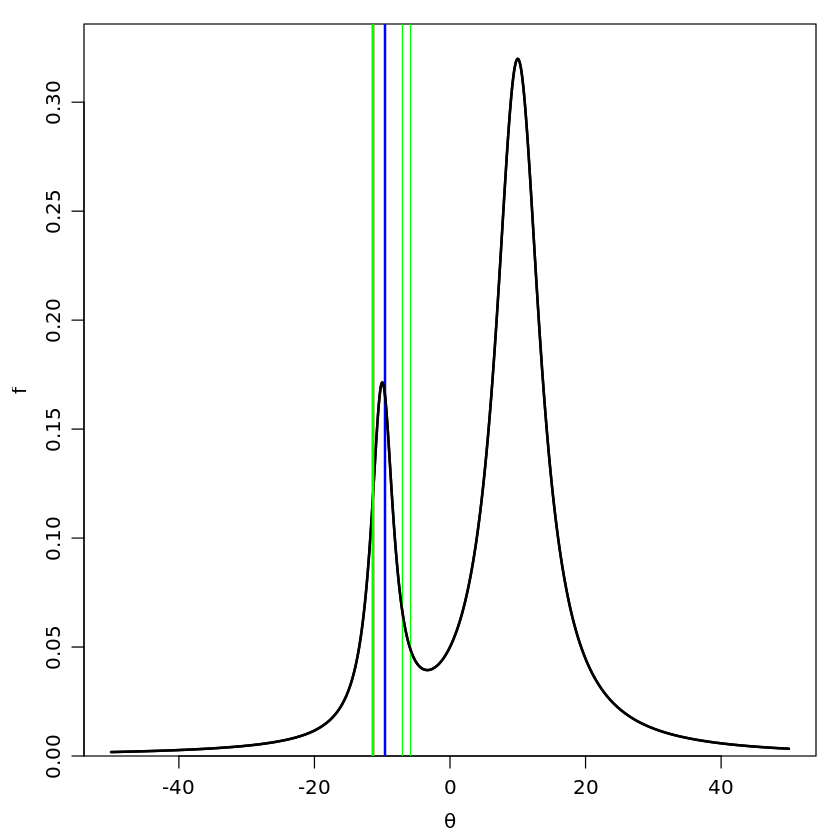

   8 Proposal:   -8.97  =>  Current:   -8.97 ACCEPTED


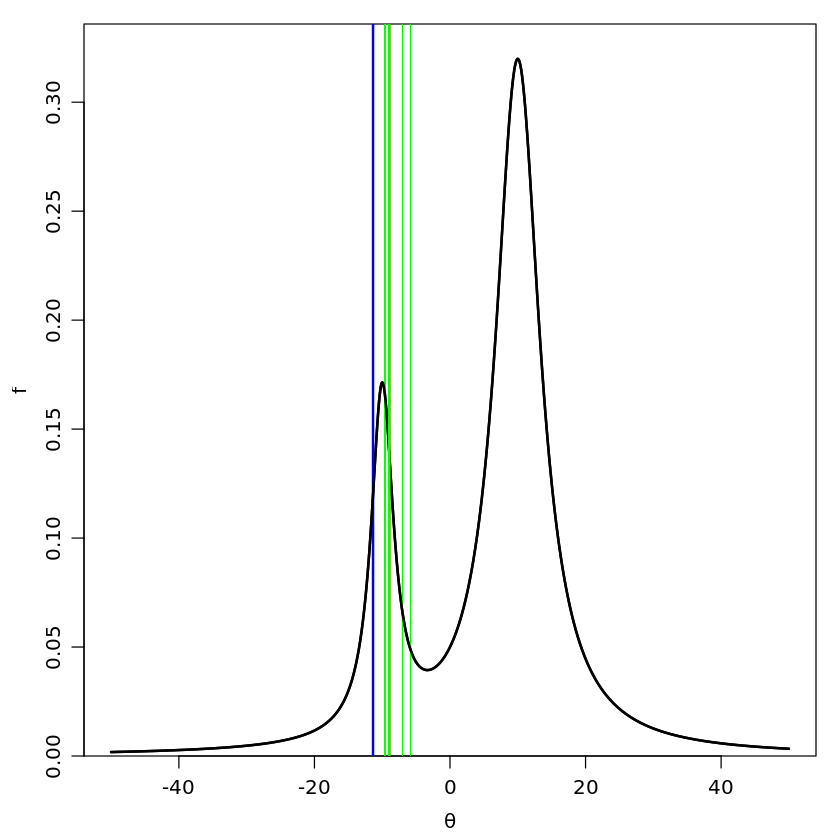

In [2]:
##### C.A.L. Bailer-Jones, Practical Bayesian Inference, 2017
##### Version 2017-03-24. CC-BY-4.0 licence (see README file)

##### MCMC demonstration in 1D

plotev    <- TRUE  # do we want to plot the evolution?
delay     <-  10    # time delay in seconds between steps in evolution
thetaInit <- -5    # MCMC initialization
sampleSig <-  3   # MCMC step size
Nsamp     <-  1e5  # number of MCMC samples

source("metropolis.R") # provides metrop()

# Test function
testfunc <- function(theta) {
  return(dcauchy(theta, -10, 2) + 4*dcauchy(theta, 10, 4))
}

# Interface to test function for metrop()
testfunc.metrop <- function(theta) {
  return(c(0,log10(testfunc(theta))))
}

# Establish range, and plot test function
x <- seq(from=-50, to=50, length.out=1e4)
y <- testfunc(x)
ymax <- 1.05*max(y)
# Compute normalization function: used later to put on same as histogram
Zfunc <- sum(y)*diff(range(x))/(length(x))
par(mfrow=c(1,1), mar=c(3.0,3.0,0.5,0.5), oma=c(0.5,0.5,0.5,0.5), 
    mgp=c(2.2,0.8,0), cex=1.0)
plot(x, y, type="l", yaxs="i", lwd=2, ylim=c(0, ymax), 
     xlab=expression(theta), ylab="f")

# Run MCMC
set.seed(120)
chain <- metrop(func=testfunc.metrop, thetaInit=thetaInit, Nburnin=0, 
                Nsamp=Nsamp, sampleCov=sampleSig^2, verbose=Inf, demo=TRUE)

# Plot evolution of chain to the screen
if(plotev) {
  par(mfrow=c(1,1), mar=c(3.0,3.0,0.5,0.5), oma=c(0.5,0.5,0.5,0.5), 
      mgp=c(2.2,0.8,0), cex=1.0)
  for(i in 1:nrow(chain$thetaPropAll)) {
    plot(x, y, type="l", yaxs="i", lwd=2, ylim=c(0, ymax), 
         xlab=expression(theta), ylab="f")
    if(i==1) {
      segments(thetaInit, 0, thetaInit, 1, col="blue", lwd=2)
      Sys.sleep(delay)
    } else { 
      segments(chain$funcSamp[1:(i-1),3], 0, chain$funcSamp[1:(i-1),3], 
               ymax, col="green")
      segments(chain$funcSamp[i-1,3], 0, chain$funcSamp[i-1,3], ymax, 
               col="blue", lwd=2)
    }
    lines(x, y, lwd=2) # replot to bring to front
    segments(chain$thetaPropAll[i,1], 0, chain$thetaPropAll[i,1], ymax, 
             col="red", lwd=2)
    cat(formatC(i, digits=3), "Proposal: ", formatC(chain$thetaPropAll[i,1], 
                                            digits=2, width=6, format="f"))
    Sys.sleep(delay)
    segments(chain$funcSamp[i,3], 0, chain$funcSamp[i,3], ymax, 
             col="green", lwd=2)
    cat("  =>  Current: ", formatC(chain$funcSamp[i,3], digits=2, width=6, 
                                   format="f"), append=TRUE)
    if(chain$funcSamp[i,3]==chain$thetaPropAll[i,1]) {
      cat(" ACCEPTED")
    }
    cat("\n")
    Sys.sleep(delay)
  }
}

# Plot function, samples, and histogram density estimate of samples. The
# histogram is rescaled to have the same normalization as the function.
# Samples outside the range of x are not included in the histogram.
# lines(type="s") plots the vertical steps at the x values given, so we 
# must supply it with the histogram breaks, not midpoints. There is one 
# more break than counts in the histogram, and each element of hist$counts
# is associated with the lower break, so we must provide an additional 
# count=0 to complete the histogram.
pdf("mcmc_demo.pdf", 4, 4)
par(mfrow=c(1,1), mar=c(3.2,3.2,0.5,0.5), oma=c(0.5,0.5,0.5,0.5), 
    mgp=c(2.2,0.8,0), cex=1.0)
plot(x, y, type="n", yaxs="i", ylim=c(0, 1.05*max(y)), 
     xlab=expression(theta), ylab="f")
# Uncomment the following if you want to plot every sample
#segments(chain$funcSamp[,3], 0, chain$funcSamp[,3], 1, col="green")
lines(x, y, lwd=1) # plot function
# Build and plot histogram of samples
sel <- which(chain$funcSamp[,3]>=min(x) & chain$funcSamp[,3]<=max(x))
hist <- hist(chain$funcSamp[sel,3], breaks=seq(from=min(x), to=max(x), 
                                               length.out=100), plot=FALSE)
Zhist <- sum(hist$counts)*diff(range(hist$breaks))/(length(hist$counts))
lines(hist$breaks, c(hist$counts*Zfunc/Zhist,0), type="s", lwd=1)
dev.off()

# Plot ACF
acor <- acf(chain$funcSamp[,3], lag.max=1e3, plot=FALSE)
plot(acor$lag, acor$acf, xlab="lag", ylab="ACF", type="l", lwd=2)
abline(h=0, lty=3, lwd=1)
